In [124]:
import pygmsh
# import meshio
import matplotlib.pyplot as plt
import numpy as np

from matplotlib.tri import Triangulation

## Step 1 . Meshing the Domain

Note: currently using pygmsh, which is a straight forward way to mesh the domian. However, cannot seem to figure out how to do rectangular elements. 

In [2]:
import pygmsh
degree = 2 ## this is the degree of the elements that we are planning to use

# Create a geometry and generate a mesh
with pygmsh.geo.Geometry() as geom:
    # Define a square geometry (side length = 1)
    square = geom.add_rectangle(xmin=0, xmax=10, ymin=0, ymax=1, z=0)
                              # mesh_size=0.2)  # Approximate mesh size)

    geom.el_order = 2
    # Generate the mesh
    mesh =  geom.generate_mesh(dim = 2, algorithm=6, order = degree) ## order 2 changes from linear to quadratic, element order
    mesh.write("triangle_mesh.vtk")  # Save as a .vtk file for visualization

points = mesh.points  # Coordinates of the mesh points
print("Mesh Points:")
print(points)

# Access the cells (elements) of the mesh
cells = mesh.cells_dict  # A dictionary of cell types and their connectivity
print("\nMesh Cells (Elements):")
for cell_type, connectivity in cells.items():
    print(f"{cell_type}: {connectivity}")


Mesh Points:
[[ 0.    0.    0.  ]
 [10.    0.    0.  ]
 [10.    1.    0.  ]
 [ 0.    1.    0.  ]
 [ 1.    0.    0.  ]
 [ 2.    0.    0.  ]
 [ 3.    0.    0.  ]
 [ 4.    0.    0.  ]
 [ 5.    0.    0.  ]
 [ 6.    0.    0.  ]
 [ 7.    0.    0.  ]
 [ 8.    0.    0.  ]
 [ 9.    0.    0.  ]
 [ 0.5   0.    0.  ]
 [ 1.5   0.    0.  ]
 [ 2.5   0.    0.  ]
 [ 3.5   0.    0.  ]
 [ 4.5   0.    0.  ]
 [ 5.5   0.    0.  ]
 [ 6.5   0.    0.  ]
 [ 7.5   0.    0.  ]
 [ 8.5   0.    0.  ]
 [ 9.5   0.    0.  ]
 [10.    0.5   0.  ]
 [ 9.    1.    0.  ]
 [ 8.    1.    0.  ]
 [ 7.    1.    0.  ]
 [ 6.    1.    0.  ]
 [ 5.    1.    0.  ]
 [ 4.    1.    0.  ]
 [ 3.    1.    0.  ]
 [ 2.    1.    0.  ]
 [ 1.    1.    0.  ]
 [ 9.5   1.    0.  ]
 [ 8.5   1.    0.  ]
 [ 7.5   1.    0.  ]
 [ 6.5   1.    0.  ]
 [ 5.5   1.    0.  ]
 [ 4.5   1.    0.  ]
 [ 3.5   1.    0.  ]
 [ 2.5   1.    0.  ]
 [ 1.5   1.    0.  ]
 [ 0.5   1.    0.  ]
 [ 0.    0.5   0.  ]
 [ 0.5   0.5   0.  ]
 [ 1.5   0.5   0.  ]
 [ 9.5   0.5   0.  ]


40


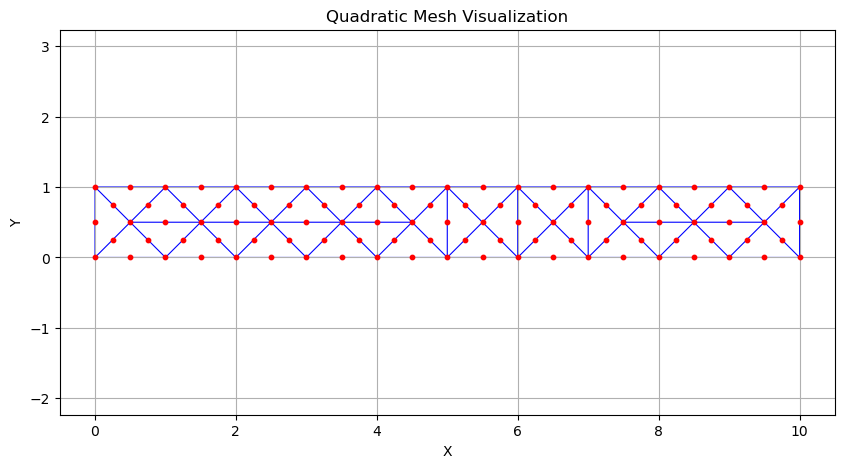

In [3]:
## Visualising the mesh

points = mesh.points  # Coordinates of the mesh points
cells = mesh.cells_dict  # Dictionary of cell types and their connectivity

# if 'triangle' in cells: ## this relies on the quadratic elements
if 'triangle6' in cells: ## this relies on the quadratic elements
    triangles = np.array(cells['triangle6'])[:,:3] ## only grab the corner nodes and not the midnotes
else:
    raise ValueError("The mesh does not contain triangular elements.")

# Prepare data for Triangulation
x, y = points[:, 0], points[:, 1]
triangulation = Triangulation(x, y, triangles)
print(len(triangles))

# Plot the mesh
plt.figure(figsize=(10, 5))
plt.triplot(triangulation, color='blue', lw=0.8)
plt.scatter(x, y, color='red', s=10, zorder=5)  # Highlight the points
plt.title("Quadratic Mesh Visualization")
plt.xlabel("X")
plt.ylabel("Y")
plt.axis("equal")
plt.grid(True)
plt.show()

## Set Up  Key Element Functions
#### Integration Points

We do the intergration of the differential equation over each element. Each element exists in the physical space, so may have different volume and coordinates. To make the coding easier we map each triangle to an isoparametric triangle element which has corners at [0,0],[1,0] and [0,1] for triangles. This way the shape functions and integration points that we use to describe the solution variable are the same between all the elements and we dont need to calculate them differently. The key here would be to apply a Jacobian transformation matrix between the two coordinate systems (local in the isoparameteric space and gloabl which is the physical space).

We use Gaussian integration points, which different depending on what type of isoparametric element we use: triangles vs quadrilateral, order and volume of the element.
The total weights must add up to the volume/area of the isoparametric element. We have to have enough intrgeration points for the order. Having fewer than the required number of points leads to inaccurace integration (and hence solution) but having more points has no impact (apart from repeating unnecessary calculations and increasing the computation time)



In [4]:
## Quadratic tirangular elements
def integrationPoints(degree):
    Points = np.array([[1/6.,2/3.],[1/6.,1/6],[2/3.,1/6.]])
#     Points = np.array([[0.5,0.5],[0.5,0],[0,0.5]])
    weights = np.array([1.,1.,1.,1.]) * 1/6.

    return Points, weights


#### Basis Functions

The basis functions also depend on the type of element we use. Every node in the element has a corresponding basis function. It must be 1 at the node and 0 and other nodes. FOr linear elements the basis functions are linear functinos from one node to the nest, for quadratic elements the functinos vary quadratically along the edge of the element. (add some visualisation of the basis functions)

We have to keep in mind the order of the nodes in the elemnt so we have have correct order of the basis functions. IN particularly for quadratic and higher elements, since there are corner nodes and mid-side nodes.

It is usual practice to have the corner nodes first in clockwise or counter clockwise order and then midside nodes. 

Given we are using pygmsh which has the nodes in this order going counter-clockwise, we will stick with that order here.

for reference: https://www.geophysik.uni-muenchen.de/~igel/Lectures/NMG/08_finite_elements_basisfunctions.pdf

In [40]:
#This is for elements in 2D
def basis_functions(degree, point):
    ## Givent the coordinate of the integration point in the local coordinate system
    ## we evaulate the basis functions at that point 
    
    r = point[0]
    s = point[1]
    
    ## quadratic elements
    if degree==2:
        basis_functions = np.zeros((6,)) ## for each basis function
        ## Corner nodes first
        basis_functions[0] = (1 - nu - eta)*(1-2*eta-2*nu)
        basis_functions[1] = eta * (2*eta - 1)
        basis_functions[2] = nu * (2*nu - 1)#
        #mid side nodes:
        
        basis_functions[3] = 4*eta*(1-eta-nu)
        basis_functions[4] = 4*eta*nu
        basis_functions[5] = 4*nu*(1-eta-nu)
        
        

For the derivatives of the basis functions we have to take into account that for 2D space there are actually three derivatives exist. There is:

$$\frac{\partial }{\partial u},\frac{\partial}{\partial r}$$

So when calculating the derivatives of basis functions instead of a vector we have a matrix of dimension [m,n] where m is the space dimension (in this case 2) and n is the number of nodes in the element (ie shape functions). So each column is the derivative of a shape functions and each row is the derivative of all shape functions with respect to a dimension). We will call this matrix B:

$$
\begin{bmatrix}
\frac{\partial{N_0}}{\partial r} & \cdots & \frac{\partial{N_5}}{\partial r} \\
\frac{\partial{N_0}}{\partial s}  & \cdots & \frac{\partial{N_5}}{\partial s} \end{bmatrix}
$$
where $N_0 \cdots N_5$ are the basis functions.

In [89]:

def basis_functions_der(degree, point):
    ## Givent the coordinate of the integration point in the local coordinate system
    ## we evaulate the basis functions at that point 

    ## quadratic elements
    if degree==2:
        dNr = basis_functions_dNr(2,point)
        dNs = basis_functions_dNs(2,point)
        basis_functions = np.vstack((dNr,dNs))
        
    return basis_functions
                
def basis_functions_dNr(degree,point):
    r = point[0]
    s = point[1]

    if degree==2:
        dNr = np.zeros((6,)) ## for each basis function
        ## Corner nodes first
        dNr[0] = -3. + 4. * r + 4. * s
        dNr[1] = -1. + 4. * r
        dNr[2] = 0.

        dNr[3] = 4. - 8. * r - 4. * s
        dNr[4] = 4. * s
        dNr[5] = -4*s
    return dNr
        
def basis_functions_dNs(degree,point):
    r = point[0]
    s = point[1]
    
    if degree==2:
        dNs = np.zeros((6,)) ## for each basis function
        ## Corner nodes first
        dNs[0] = -3. + 4. * r + 4. * s
        dNs[1] = 0.
        dNs[2] = -1. + 4. * s

        dNs[3] = -4. * r
        dNs[4] =  4. * r
        dNs[5] = 4. - 4. * r - 8. * s

    return dNs
        
               
        

### Jacobian
Give a couple of sentances about Jacobian.
Jacobian matrix describes how mapping of physical space with coordinates (x,y,z) to the isoparametric space (r,s)
$$
\begin{equation}
\it{J} = 
\begin{bmatrix}
\frac{\partial{x}}{\partial r} & \frac{\partial{y}}{\partial r} \\
\frac{\partial{x}}{\partial s} & \frac{\partial{y}}{\partial s} \\
\end{bmatrix}
= 
\begin{bmatrix}
\sum\frac{\partial{N_i}}{\partial r}x_i & \sum\frac{\partial{N_i}}{\partial r}y_i \\
\sum\frac{\partial{N_i}}{\partial s}x_i & \sum\frac{\partial{N_i}}{\partial s}y_i \\
\end{bmatrix}
\end{equation}
$$
where $i$ is the shape function index

This is where it is important to keep track of the nodes local node IDs and their physical coordinates

In [90]:
def Jacobian(degree, point, e_nodes):
    #e_nodes is numpy array (num_nodes, 2) of all the global coordinates of the nodes
    space_dim = 2 ## for now we assume dimension is 2
    
    ## in this case we are mapping 2D space to 2D so Jacobian is a square
    Jacobian_mat = np.zeros((space_dim,space_dim))
    num_corner_nodes = len(corner_points_xy)
    
    dnr = basis_functions_dNr(degree, point)
    dns = basis_functions_dNs(degree, point)

    for dim in range(2):
        Jacobian_mat[0,dim] =np.dot(dnr, e_nodes[:,dim])# x coordinate
        Jacobian_mat[1,dim] =np.dot(dns, e_nodes[:,dim])# y coordinate
    
    det = np.linalg.det(Jacobian_mat)
    return det, Jacobian_mat
        
    

## Accumulation

The heat diffusion in steady state is the simplest example to solve. For this example let's take the domain and heat it on one side to temprature T1 and keep it cool at T2 at another domain. Then the temperature in the domain must satisfy the following equation:

$$\frac{\partial u}{\partial t}= c^2 \frac{\partial ^2 u}{(\partial x)^2},$$


where $c$ is the thermal diffusivity of the domain.

This is a second order differential equation in space and first in time. However, at steady state there is no change in temperature with time, so the solution for temperature is a linear change in temperature along the bar. We can use derivatives of the basis functions to describe the temprature along the domain.


For this step we perform the actual accumulation of the linear system of equations of the form $Ax=b$. Where A is the matrix of size [n,n], where $n$ is the number of nodes in the system. It captures the interactions between the nodes. Each row corresponds to a specific node and the columns in that row will only be non-zero if that node is connected to other nodes, ie the nodes are part of the same element. 
ADD AN IMAGE VISUALISING THIS and need to explain further the concept of local and gloabl node IDs.

In [113]:
num_nodes = len(points)
MatrixThermalConduct = 51.9615 # this depends on the material 
space_dim = 2
print("There are ", num_nodes, " nodes in the mesh")
A_matrix = np.zeros((num_nodes, num_nodes))
b = np.zeros((num_nodes,))

There are  103  nodes in the mesh


In [114]:


## Now we iterate through each element in the mesh 
for element in cells['triangle6']:
    
    # get the list of integration points and the list of global IDs for nodes in the element
    IntegrationPoints, IP_weights = integrationPoints(degree)
    e_nodes_xy = points[element][:,:space_dim]
    
    ## we first get the local stiffness matrix for the element by accumulating
    ## over all the integration points
    LHS = np.zeros((len(element), len(element)))
    for IP, weight in zip(IntegrationPoints,IP_weights):
        B = basis_functions_der(degree, IP)
        BT = B.transpose() * MatrixThermalConduct
        BT = np.matmul(BT, B)
        detJ, _ = Jacobian(degree, IP, e_nodes_xy)
        BT = BT * weight*(detJ) 
        LHS += BT # this is a element level stiffness matrix
        
    ## once LHS has been accumulated over all the integration points, we add it to the global matrix A_matrix
    ## this uses the global node IDs to determine which indices are updates
    for i in range(len(element)):
        for j in range(len(element)):
            col = int(element[i])
            row = int(element[j])
            A_matrix[row][col]+= LHS[int(j)][int(i)]


## Boundary Conditions

Applying Dirichlet boundary conditions: 
set the tempreature on the right side of the domain to be 10 degree and the left side of the domain to be 0. Due to dteady state differential equation that we are solving and the simple rectangular domain we would expect a linear vairation of temperature from right to left. 

To set Dirichlet boundary condition we overwirte the rows in matrix A that correspond to the nodes that lie on the boundry. We set the rows to be zero everywhere apart from 1 along the diagonal. Additionally we set the value on right hand side vecotr (b vector) to the boundary condition value (in this case 0 for nodes on the left boundary and 10 for right boudnary). This ensure that the solution vector x will have the correct temperature along those boundaries.

In [128]:
# Boundary COnditions
## identify the nodes along the right and left boundaries
right_ = np.where(points[:, 0] == 10)[0]
left_ = np.where(points[:, 0] == 0)[0]

## Check that the coordinates of the nodes in the boudnaries lie on the min and max x-values of domain
print("right:",points[right_], "\n\nleft:",points[left_])
## Apply temperature of 100  on left and 0 on the right
for node in right_:
    A_matrix[node,:] = 0
    A_matrix[node, node] = 1.
    b[node] = 0.
    
for node in left_:
    A_matrix[node,:] = 0
    A_matrix[node, node] = 1.
    b[node] = 100.

right: [[10.   0.   0. ]
 [10.   1.   0. ]
 [10.   0.5  0. ]] 

left: [[0.  0.  0. ]
 [0.  1.  0. ]
 [0.  0.5 0. ]]


In [129]:
## solve the linear systme of equations
x = np.linalg.solve(A_matrix, b)


## Visualise the solution

Print the nodes on a map and colour code them based on the temperature in the solution vector. This is a quick and easy way to check for linear relationship. 
Note: next need to write the result to vtk file for better visualisation. 


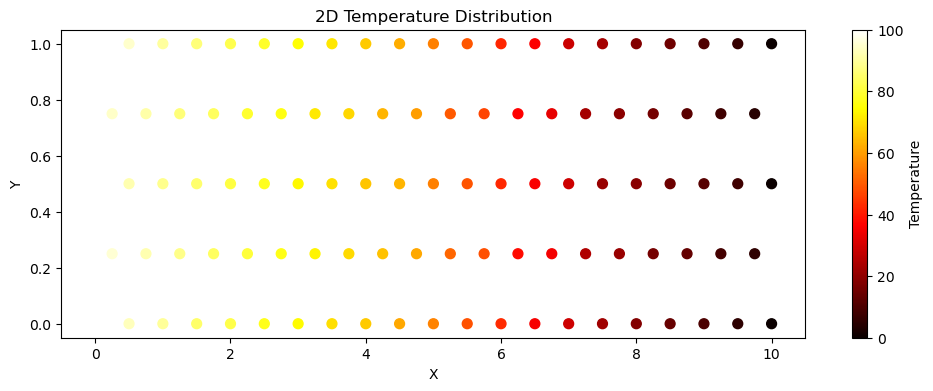

In [130]:
plt.figure(figsize=(12, 4))  
plt.scatter(points[:, 0], points[:, 1], c=x, cmap='hot', s=50)
plt.colorbar(label="Temperature")
plt.xlabel("X")
plt.ylabel("Y")
plt.title("2D Temperature Distribution")
plt.show()